# (4) Simulator function

## Set-up

The aim of this notebook is to make the simulator function to be later used by the SMC-ABC program. First need to import the SSA function from `SSA_file.jl`. 

In [6]:
include("./SSA_file.jl"); using .SSAmod;
include("./extract_gens.jl"); using .extract;

As we did in notebook 2, let's split up the 2-d array defining the lineage data into a 3-d array where within each lineage data is split up into its respective generations. Reproducing from notebook 2:

In [7]:
using DelimitedFiles;

In [8]:
filelist = readdir("Analysis_MC4100_37C/MC4100_37C/"); # take the file names - each file is for a different lineage.
raw_data = []; # define the raw data array.
for (i,file) in enumerate(sort!(filelist))
    push!(raw_data,readdlm(string("Analysis_MC4100_37C/MC4100_37C/", file), ',', Float64, '\n'))
end

In [9]:
fluor_all_lins = [raw_data[x][:,4] for x in 1:length(raw_data)];
vol_all_lins = [raw_data[x][:,3] for x in 1:length(raw_data)];

fluor_sep_all_lins = extract_gens(raw_data,4); # the fluor. data for each lineage.
vol_sep_all_lins = extract_gens(raw_data,3); # the vol. data for each lineage.
times_sep_all_lins = extract_gens(raw_data,1); # the time pt. data for each lineage.

We also need to import the exponential growth rates for each generation in each lineage and the molecule number proportionality for each lineage. Note that allow there are typically 70 cell-cycle generations in each lineage we look only at the first 69 generations in each lineage.

In [28]:
fpm = readdlm("MN_props.csv")[1];
exp_grs = readdlm("exp_grs_all.csv", ',', Float64, '\n');

- `exp_grs[i,j]` gives the expermentally determined exponential cell growth rate, $\theta$, for lineage $i$, generation $j$ (note $V(t) = V_0 e^{\theta t}$).

Now let's get the molecule number for each generation of each lineage.

In [30]:
num_sep_all_lins = []; # sep into gens.
for i in 1:length(fluor_sep_all_lins)
    push!(num_sep_all_lins,fluor_sep_all_lins[i]./fpm)
end

# un-sep including 70th gen (must remove later)
num_all_lins = fluor_all_lins./fpm

# un-sep including 70th gen (must remove later)
conc_all_lins = [num_all_lins[x]./vol_all_lins[x] for x in 1:length(fluor_all_lins)];

Additionally let's collect the initial condition on volume and fluorescence for each generation in each lineage. The initial condition of fluorescence can then be converted to molecule number using the proportionality constants.

In [31]:
v0_n0_th = []; # 2-d array to storing (1) the initial values of vol (2) molecule #  and (3) theta for each gen in each lin
for x in 1:length(fluor_all_lins) # the lin loop
    v0_n0_th_x = [];
    for y in 1:length(fluor_sep_all_lins[x]) # the gen loop 1 --> 69
        num = fluor_sep_all_lins[x][y][1]./fpm
        push!(v0_n0_th_x, [vol_sep_all_lins[x][y][1], num, exp_grs[x,y]])
    end
    push!(v0_n0_th, v0_n0_th_x)
end

- `v0_n0_th[i][j]` gives the starting volume, starting molecule number and exponential growth rate `[v0,n0,exp_gr]` for lineage $i$ generation $j$.

In [32]:
v0_n0_th[1][14]

3-element Array{Float64,1}:
   1.92703
 235.8596504808919
   0.02803108189067706

## The simulator function

Remember our aim is to construct simulations for each lineage of data. Let's look at lineage 1. We loop over each generation of lineage 1 data, and construct a corresponding SSA sim.

- `lin_data` the data split over generations for each lineage, this gives the dimensional form of the data.
- `inf_params` is the five parameters to be inferred in the model, in the order specified in notebook 3.
- `ics` the initial conditions and exp growth rate for each generation in the lineage.

In [38]:
function Single_lin(lin_data, inf_par, ics) # arguments are wrt each lineage.
    SSA_data_n = [];
    SSA_data_c = [];
    SSA_data_v = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA(1, inf_par, ics[i], length(gen)-1); # for each gen run the SSA with correct ics.
        append!(SSA_data_n, ssa[1]); append!(SSA_data_c, ssa[2]); append!(SSA_data_v, ssa[3]);
    end
    return SSA_data_n, SSA_data_c, SSA_data_v # return in the same order as the SSA.
end

Single_lin (generic function with 1 method)

For use in GpABC I will need to select one of molecule numbers of concentration as the output of the `Single_lin` function. Let try concentration for the moment since it also incorporates information regarding the changing volume.

In [50]:
single = @time Single_lin(num_sep_all_lins[1], [5.0,0.3,1.0,0.5,0.001], v0_n0_th[1]); # do for first gen.

  0.020005 seconds (53.40 k allocations: 4.645 MiB)


In [51]:
nums = single[1]; expt_n = num_all_lins[1][1:length(single[1])];
concs = single[2]; expt_c = conc_all_lins[1][1:length(single[1])];
vols = single[3]; expt_v = vol_all_lins[1][1:length(single[1])];

In [45]:
using PyPlot;

Let's compare this carefully chosen trajectory to the experimental data of lineage 1.

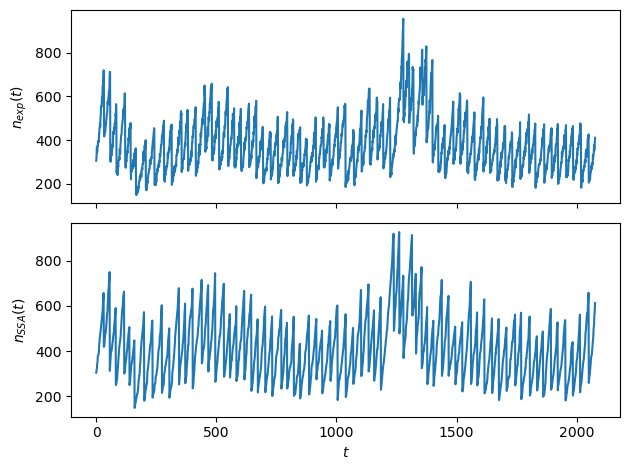

In [52]:
fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"n_{exp}(t)"); axs[2].set_ylabel(L"n_{SSA}(t)"); 
axs[1].plot(range(0,length(expt_n)-1,step=1),expt_n); axs[2].plot(range(0,length(nums)-1,step=1),nums);

Hmmm... Seems okay! Let's also compare the concentrations.

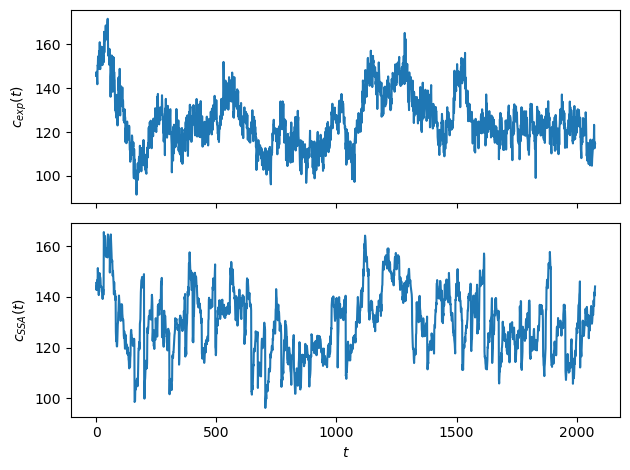

In [53]:
fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{exp}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(0,length(expt_c)-1,step=1),expt_c); axs[2].plot(range(0,length(concs)-1,step=1),concs);

In this case it shows the set of params is not so good. Could combine distance measures on concentration and moelcule number to give some overall distance function?

Clearly these are not optimised params! Let's check the Euclidean distance between these sets of params.

In [55]:
y = sqrt(sum((nums .- expt_n).*(nums .- expt_n)))

7054.989649451708

In [56]:
distance_n = sqrt(sum((nums .- expt_n).*(nums .- expt_n)));
distance_c = sqrt(sum((concs .- expt_c).*(concs .- expt_c)));
print(distance_n,"\t",distance_c)

7054.989649451708	590.4991524739451

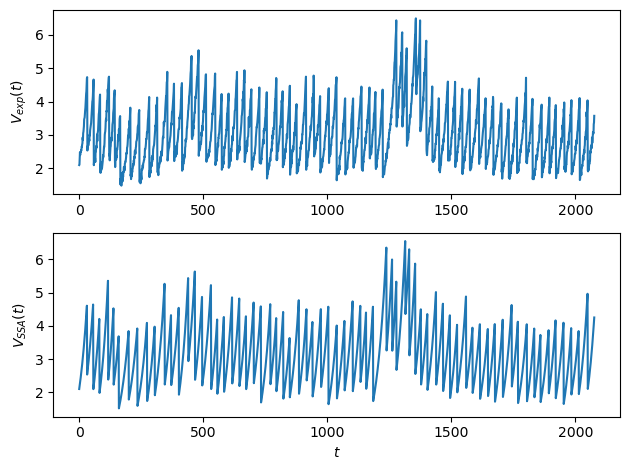

In [57]:
fig, axs = PyPlot.subplots(2, 1, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"V_{exp}(t)"); axs[2].set_ylabel(L"V_{SSA}(t)"); 
axs[1].plot(range(0,length(expt_v)-1,step=1),expt_v); axs[2].plot(range(0,length(vols)-1,step=1),vols);

Okay, so the volumes are given very well by the exponential growth! Experimenting with the parameter values for $d = 0$ seems to suggest that some dependence of the rates on the volume better to minimise the distance. 

## Determination of suitable thresholds for SMC-ABC

By comparing SSA mean trajectories to single trajectories we can get an estimate for the expected minimum deviation from the mean trajectory which will provide us with our minimum threshold distance in the SMC-ABC.

In [60]:
using Statistics;

In [61]:
# sim is the number of sims to average over.
function Single_lin_mean(sim::Int64, lin_data, inf_par, ics) # arguments are wrt each lineage.
    SSA_data_n = [];
    SSA_data_c = [];
    SSA_data_v = [];
    for (i,gen) in enumerate(lin_data)
        ssa = SSA(sim, inf_par, ics[i], length(gen)-1); # for each gen run the SSA with correct ics.
        append!(SSA_data_n, mean(ssa[1],dims=1)); append!(SSA_data_c, mean(ssa[2],dims=1)); append!(SSA_data_v, mean(ssa[3],dims=1));
    end
    return SSA_data_n, SSA_data_c, SSA_data_v # return in the same order as the SSA.
end

Single_lin_mean (generic function with 1 method)

In [62]:
many = @time Single_lin_mean(1000, num_sep_all_lins[1],[5.0,0.3,1.0,0.5,0.001], v0_n0_th[1]); # do for first gen.

 12.422251 seconds (47.35 M allocations: 4.249 GiB, 3.20% gc time)


In [63]:
m_nums = many[1]; m_concs = many[2]; m_vols = many[3];

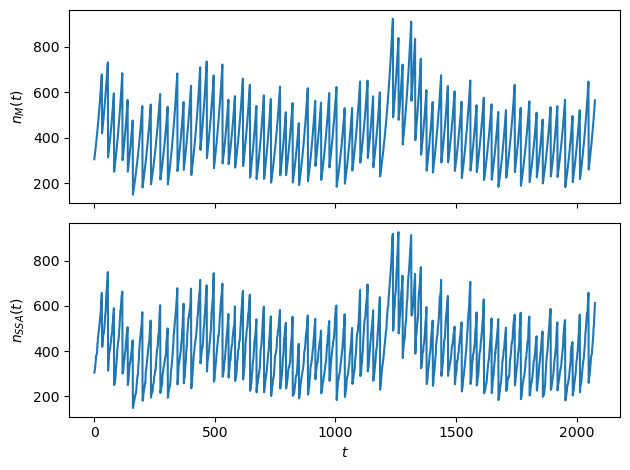

In [64]:
fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"n_{M}(t)"); axs[2].set_ylabel(L"n_{SSA}(t)"); 
axs[1].plot(range(0,length(m_nums)-1,step=1),m_nums); axs[2].plot(range(0,length(nums)-1,step=1),nums);

In [65]:
thres_dist = sqrt(sum((nums .- m_nums).*(nums .- m_nums)))
thres_dist_conc = sqrt(sum((nums .- m_nums).*(nums .- m_nums)))

1090.8126312121628

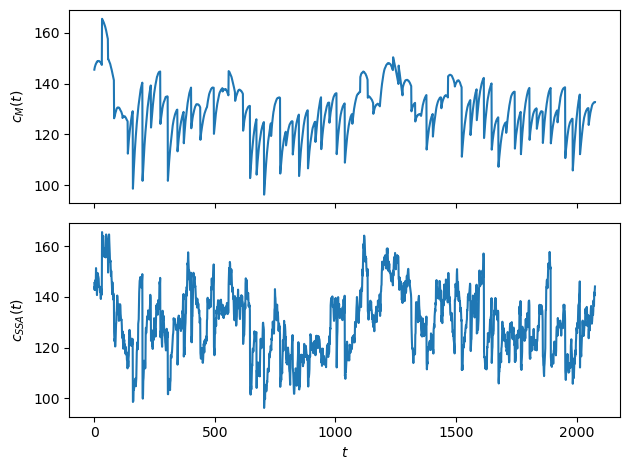

In [66]:
fig, axs = PyPlot.subplots(2, 1, sharex = true, tight_layout = true);
axs[2].set_xlabel(L"t"); axs[1].set_ylabel(L"c_{M}(t)"); axs[2].set_ylabel(L"c_{SSA}(t)"); 
axs[1].plot(range(0,length(expt_c)-1,step=1),m_concs); axs[2].plot(range(0,length(concs)-1,step=1),concs);

In [67]:
thres_dist_c = sqrt(sum((concs .- m_concs).*(concs .- m_concs)))

322.6267244901444

It seems about 1000 is a decent threshold for the molecule number inference, while 300 is a decent threshold for the concentration inference. These values are chosen higher than stated above since we are comparing two single trajectories and hence are likely to get a fair bit of rejection. Note that different SSA params return different results for this hence the minimum threshold values found should be treated with great caution.